In [1]:
import numpy as np
import pandas as pd

In [2]:
from utils.data_funcs import *

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import time
import os

In [5]:
import matplotlib.pyplot as plt

# Model Inspiration

The encoder/decoder LSTM presented in this notebook is heavily inspired by the following papers:

"A Novel Intervention Recurrent autoencoder for real time forecasting and non-pharmaceutical intervention selection to curb the spread of Covid-19 in the world":
https://www.medrxiv.org/content/10.1101/2020.05.05.20091827v2.full

"Forecasting Treatment Responses Over Time Using Recurrent Marginal Structural Networks":
https://vanderschaar-lab.com/papers/nips_rmsn.pdf

The model is broken into an LSTM encoder and an LSTM decoder. The encoder takes as input a sequence of day features which includes information on yesterdays log of daily covid cases, state-relevant features, and that day's mobility data. It is trained to predict the log of daily covid cases for the last day of the sequence. The hidden state and cell state of the encoder are then used to initialize the decoder, which takes as input a sequence of policy strictness levels and yesterday's log of daily covid cases. From these features, it trains to predict the log daily covid cases for that particular day. To make simulations, we seed the encoder with a sequence of days from the dataset, and then we initialize the decoder. Afterward, we feed in couterfactual policy strictness levels to the decoder and recursively use its output as input for yesterdays log daily covid cases. This allows us to forecast log daily covid cases in the future under a policy plan of our choosing. Note that the policy in question for these model is school closures. However, since these closures are highly correlated, we can think of the model as assessing the effect of closures in general.

# Function to get input data for LSTM model

In [6]:
# Function for compiling an initial input_df with all relevant features for our model
def get_input_df():
    # Get state policy data
    input_df = get_state_policy_data(fill=True)

    # Keep relevant columns
    policy_of_interest = POLICIES[0]
    input_df = input_df[['region_name', 'date', policy_of_interest]]

    # Rename region_name to state
    input_df.rename(columns={'region_name': 'state'}, inplace=True)

    # Get US daily case data for 50 states
    us_state_daily = get_state_covid_daily_data().reset_index(drop=True)
    not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
    us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

    # Merge daily cases with input df
    input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date']).dropna().reset_index(drop=True)

    # Get cumulative cases and add as col to input df
    input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=1)

    # Merge pop density with input df
    input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

    # Merge wage data with input df
    input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

    # Merge political data with input df
    input_df = input_df.merge(get_political_data(), on=['state'], how='left')

    # Merge mobility data with input df
    input_df = input_df.merge(get_at_away_6_data(), on=['state', 'date'], how='left')

    # Take Y = log(Y + 1) for daily case counts
    input_df['cases'] = np.log(input_df['cases'] + 1)
    input_df['yesterdays_active_cases'] = np.log(input_df['yesterdays_active_cases'] + 1)
    
    return input_df

# Function to convert input data to format needed for LSTM

In [7]:
# Takes an input dataframe with fields state, deaths, date, cases, etc.
# For the encoder, we generate sequences of length time_steps for the input.
# The days in these sequences contain all features of input_df 
# other than state, death, date and cases. The cases feature becomes the 
# output y that we will train the encoder to predict. Note, each sequence of 
# seven days has one output value to be predicted, which is the daily case 
# value for the final day of the sequence.
# For the decoder, we also generate sequences of length time_steps for 
# inputs. The days in these sequences have two features, yesterdays daily cases
# and todays policy strictness value. Like before, the cases features becomes 
# the output y to predict. Note, each sequence of 
# seven days has one output value to be predicted, which is the daily case 
# value for the final day of the sequence.
def create_dataset (input_df, time_steps = 7):
    state_to_date_to_index = {}
    temp = input_df
    e_xs, e_ys , d_xs, d_ys = [], [], [], []
    running_index = 0
    for name_df, df in input_df.groupby(['state']):
        date_to_index = {}
        y = df['cases'].to_numpy()
        X = df.drop(columns=['state', 'deaths', 'date', 'cases']).to_numpy()
        
        for i in range(len(X)-time_steps):
            # We only use time periods for which there exists
            # an encoder week and a decoder week
            if (i < len(X) - (time_steps * 2)):
                # Grab encoder data
                e_v = X[i:i+time_steps, :]
                e_xs.append(e_v)
                # e_ys.append(y[i+time_steps - 1])
                e_ys.append(y[i:i+time_steps])
                
                # Grab decoder data
                d_v = X[(i+time_steps):(i+(time_steps*2)), 0:2]
                #d_v = [X[(i+time_steps), 0:2]]
                d_xs.append(d_v)
                d_ys.append(y[(i+time_steps):(i+(time_steps*2))])
                # d_ys.append(y[(i+(time_steps*2)-1)])
                #d_ys.append(y[i+time_steps])
                
                date_to_index[str(df['date'].iloc[i])[0:10]] = running_index
                running_index += 1
                
        state_to_date_to_index[name_df] = date_to_index
            
    return np.array(e_xs, dtype="float32"), np.array(e_ys, dtype="float32"), np.array(d_xs, dtype="float32"), np.array(d_ys, dtype="float32"), state_to_date_to_index

# Grabbing input data and formatting

In [8]:
# Grab initial dataframe
input_df = get_input_df()

# Grab time window to split training and test data
train_start = "2020-03-01"
train_end = "2020-08-01"
test_start = "2020-08-01"
test_end = "2020-10-01"
train_df = input_df.loc[(input_df['date'] >= train_start) & 
                        (input_df['date'] < train_end)].copy().reset_index(drop=True)
test_df = input_df.loc[(input_df['date'] >= test_start) & 
                        (input_df['date'] < test_end)].copy().reset_index(drop=True)

# Get input and output for training
e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np, train_dd = create_dataset(train_df)

# Get input and output for testing
e_x_test_np, e_y_test_np, d_x_test_np, d_y_test_np, test_dd = create_dataset(test_df)


/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Define Dual Purpose Encoder/Decoder Model Class

In [80]:
# Subclass to be used by both the encoder and decoder of our model
class ED_LSTM(tf.keras.Model):
    def __init__(self, hidden_dim):
        super(ED_LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(1)
        
    def call(self, input_sequence, states):
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(input_sequence, initial_state=states)
        # Dense layer to predict output token
        output = self.dense(lstm_out)
        
        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

# Training/Evaluation Functions for LSTM encoder

In [81]:
# Runs encoder on one batch and updates weights based on loss value
def encoder_train_step(input_seq, target, en_initial_states, optimizer):
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        output = en_outputs[0]
        # Calculate the loss function
        loss_fun = keras.losses.MeanSquaredError()
        loss = loss_fun(target, output)

    variables = encoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [82]:
# Evaluates encoder performance on a particular dataset
def eval_encoder(encoder, dataset):
    X = dataset[0]
    y = dataset[1]
    
    losses = []
    targets = []
    predictions = []
    
    loss_fun = keras.losses.MeanSquaredError()
    for i in range(len(X)):
        input_seq = tf.constant([X[i]])
        target = [y[i]]
        
        en_initial_states = encoder.init_states(1)
        
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        output = en_outputs[0].numpy()[0]
        
        # Calculate the loss function
        loss = loss_fun(target, output)
        losses.append(loss)
        targets.append(target)
        predictions.append(output)
    
    return np.mean(losses), predictions

In [111]:
# Trains encoder
def encoder_train(encoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix, verbose = 1):
    X = dataset[0]
    y = dataset[1]
    
    # Separate data into train and validation set randomly
    perm = np.random.permutation(range(0, len(X)))
    X = X[perm]
    y = y[perm]
    
    X_train = X[:int(.8 * len(X))]
    X_val = X[int(.8 * len(X)):]
    y_train = y[:int(.8 * len(X))]
    y_val = y[int(.8 * len(X)):]
    
    count = 0
    prev_loss = 0
    avg_losses = []
    val_losses = []
    for e in range(n_epochs):
        epoch_losses = []
        
        # Get the initial time
        start = time.time()
        
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        
        # Generate a random ordering for the data
        perm = np.random.permutation(range(0, len(X_train)))
        X_train = X_train[perm]
        y_train = y_train[perm]
        
        # Iterate over the data and train on batches of size batch_size
        for i in range(0, len(X_train), batch_size):
            if i + batch_size >= len(X_train):
                # If there is not enough data left for a full batch,
                # just train on what is leftover
                en_initial_states = encoder.init_states((len(X_train) - i))
                input_seq = tf.constant(X_train[i:(len(X_train))])
                target = tf.constant(y_train[i:(len(X_train))])
                #target = tf.reshape(tf.constant(y_train[i:(len(X_train))]), ((len(X_train) - i), 1))
            else:
                # Otherwise train on the full batch size
                input_seq = tf.constant(X_train[i:i+batch_size])
                target = tf.constant(y_train[i:i+batch_size])
                #target = tf.reshape(tf.constant(y_train[i:i+batch_size]), (batch_size, 1))
                
            # Train and get the loss value 
            loss = encoder_train_step(input_seq, target, en_initial_states, optimizer).numpy()

            # Store the loss and accuracy values
            epoch_losses.append(loss)
            
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        # record training loss for epoch
        avg_loss = np.mean(epoch_losses)
        avg_losses.append(avg_loss)
        
        # record validation loss for epoch
        val_loss, preds = eval_encoder(encoder, [X_val, y_val])
        val_losses.append(val_loss)
        
        if verbose == 1:
            print('Epoch {} Training Loss {:.4f}'.format(e + 1, avg_loss))
            print('Epoch {} Validation Loss {:.4f}'.format(e + 1, val_loss))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        else:
            if e % 10 == 0:
                print('Epoch {} Training Loss {:.4f}'.format(e + 1, avg_loss))
                print('Epoch {} Validation Loss {:.4f}'.format(e + 1, val_loss))
                print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
        if np.abs(val_loss - prev_loss) < 0.005:
            count += 1
        else:
            count = 0
            
        if count == 10:
            print("Early stopping...")
            break
            
        prev_loss = val_loss
    return avg_losses

# Training Encoder LSTM model

For the encoder LSTM, we will train on input sequences where each sequence represents a set of consecutive days, and each day will be represented by a set of features corresponding to that day (e.g. yesterday's daily case number, political index, policy strictness, etc.). After the model is trained via minimizing mean squared error, we will seed it with day sequences to obtain a hidden state and cell state to initialize the decoder LSTM.

In [150]:
# train encoder
encoder = ED_LSTM(100)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.1)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

checkpoint_dir = './training_ckpt_encoder'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder)
losses = encoder_train(encoder, [e_x_train_np, e_y_train_np], 20, 32, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Training Loss 2.0295
Epoch 1 Validation Loss 0.9250
Time taken for 1 epoch 11.1597 sec

Epoch 2 Training Loss 1.1881
Epoch 2 Validation Loss 1.6737
Time taken for 1 epoch 11.5097 sec

Epoch 3 Training Loss 0.9812
Epoch 3 Validation Loss 0.8120
Time taken for 1 epoch 10.4715 sec

Epoch 4 Training Loss 0.8318
Epoch 4 Validation Loss 0.8599
Time taken for 1 epoch 10.5392 sec

Epoch 5 Training Loss 0.7965
Epoch 5 Validation Loss 0.8895
Time taken for 1 epoch 10.4480 sec

Epoch 6 Training Loss 0.7554
Epoch 6 Validation Loss 1.1225
Time taken for 1 epoch 10.5501 sec

Epoch 7 Training Loss 0.7422
Epoch 7 Validation Loss 0.7166
Time taken for 1 epoch 11.2612 sec

Epoch 8 Training Loss 0.7131
Epoch 8 Validation Loss 0.7158
Time taken for 1 epoch 10.6882 sec

Epoch 9 Training Loss 0.7190
Epoch 9 Validation Loss 0.8247
Time taken for 1 epoch 10.4769 sec

Epoch 10 Training Loss 0.6732
Epoch 10 Validation Loss 0.6886
Time taken for 1 epoch 11.0553 sec

Epoch 11 Training Loss 0.6720
Epoch 11

# Checking encoder performance

In [211]:
e_train_loss, e_train_preds = eval_encoder(encoder, [e_x_train_np, e_y_train_np])

In [212]:
e_test_loss, e_test_preds = eval_encoder(encoder, [e_x_test_np, e_y_test_np])

In [222]:
e_y_test_np[b_window:e_window:7]

array([[7.3951077, 7.647786 , 7.104965 , 6.951772 , 6.859615 , 7.5699277,
        7.4442487],
       [7.536897 , 7.0587583, 7.430707 , 6.736967 , 6.8426833, 6.6515718,
        6.6240654],
       [7.148346 , 6.7499313, 6.349139 , 7.2137685, 7.0192966, 6.880384 ,
        7.076654 ],
       [6.8101425, 6.2709885, 7.4091363, 6.2841344, 7.6083746, 7.4809923,
        7.0587583],
       [7.4424925, 7.205635 , 6.7141705, 7.3518   , 6.437752 , 6.954639 ,
        7.0121155],
       [7.2520537, 6.2383246, 6.493754 , 6.452049 , 6.6995006, 7.0475173,
        7.037906 ],
       [6.8501263, 7.0121155, 6.558198 , 6.559615 , 6.8351846, 6.517671 ,
        7.009409 ],
       [4.406719 , 4.3694477, 4.1108737, 3.7612002, 4.1743875, 4.477337 ,
        4.6051702],
       [4.204693 , 3.871201 , 4.2195077, 4.5325994, 4.75359  , 4.465908 ,
        4.6728287],
       [3.9318256, 4.2195077, 4.26268  , 4.4426513, 4.276666 , 4.553877 ,
        4.1743875],
       [4.248495 , 2.6390574, 3.8918202, 4.4188404, 4.812184

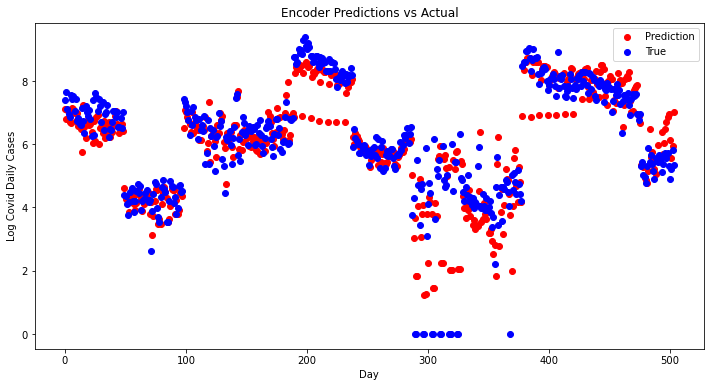

In [242]:
# Plot predictions vs actual test data
b_window = 0
e_window = 500
p = np.ndarray.flatten(np.array(e_test_preds[b_window:e_window:7]))
t = np.ndarray.flatten(e_y_test_np[b_window:e_window:7])
num = len(p)

fig, ax = plt.subplots(figsize=(12, 6))
    
# Plot the predictions and true values
ax.scatter(range(num), p, color = 'red', label = 'Prediction')
ax.scatter(range(num), t, color = 'blue', label = 'True')

ax.legend()
ax.set_title("Encoder Predictions vs Actual")
ax.set_xlabel('Day')
ax.set_ylabel('Log Covid Daily Cases')
plt.show()

In [221]:
np.array(test_preds[b_window:e_window:7])

array([[[7.1136456],
        [6.7954493],
        [7.087667 ],
        [6.77844  ],
        [6.6996727],
        [6.684874 ],
        [7.1523013]],

       [[7.112911 ],
        [6.98226  ],
        [6.748557 ],
        [6.99772  ],
        [6.580819 ],
        [6.6202435],
        [6.4897428]],

       [[5.7638865],
        [7.2386165],
        [6.5413194],
        [6.1938777],
        [6.7284107],
        [6.761044 ],
        [6.6203103]],

       [[6.6528335],
        [6.3774753],
        [6.0537124],
        [6.7478786],
        [6.0953097],
        [6.8508115],
        [6.9240594]],

       [[5.995605 ],
        [6.5267725],
        [6.551305 ],
        [6.342775 ],
        [6.735932 ],
        [6.1902404],
        [6.5671663]],

       [[6.4017873],
        [6.718587 ],
        [6.2397685],
        [6.38625  ],
        [6.372172 ],
        [6.5848007],
        [6.8975835]],

       [[7.0593705],
        [6.6314664],
        [6.5805745],
        [6.3610806],
        [6.444468 ],
 

In [141]:
e_y_train_np[0]

array([1.9459101, 1.9459101, 2.4849067, 1.9459101, 2.3978953, 2.5649493,
       3.3322046], dtype=float32)

# Training/Evaluation Functions for LSTM Decoder

In [144]:
# Runs decoder on batch of data and updates weights based on loss value
def decoder_train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        
        # Set the encoder and decoder states
        en_states = en_outputs[1:]
        de_states = en_states
                
        de_outputs = decoder(target_seq_in, de_states)
        
        # Take the actual output
        pred = de_outputs[0]
        
        # Calculate the loss function
        loss_func = keras.losses.MeanSquaredError()
        loss = loss_func(target_seq_out, pred)

    variables = decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [145]:
# Evaluate decoder on a particular dataset
def eval_decoder(encoder, decoder, dataset):
    e_X = dataset[0]
    e_y = dataset[1]
    
    d_X = dataset[2]
    d_y = dataset[3]
    
    losses = []
    targets = []
    predictions = []
    
    loss_fun = keras.losses.MeanSquaredError()
    for i in range(len(e_X)):
        input_seq = tf.constant([e_X[i]])
        target = [d_y[i]]
        
        en_initial_states = encoder.init_states(1)
        
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_states = en_states
        
        # Get the decoder outputs
        de_outputs = decoder(tf.constant([d_X[i]]), de_states)
        output = de_outputs[0].numpy()[0]
        
        # Calculate the loss function
        loss = loss_fun(target, output)
        losses.append(loss)
        targets.append(target)
        predictions.append(output)
    
    return np.mean(losses), predictions

In [146]:
# Trains decoder
def decoder_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix, verbose = 1):
    # unpack data
    e_X = dataset[0]
    e_y = dataset[1]
    
    d_X = dataset[2]
    d_y = dataset[3]
    
    # Separate data into training and validation set randomly
    perm = np.random.permutation(range(0, len(e_X)))
    e_X = e_X[perm]
    e_y = e_y[perm]
    d_X = d_X[perm]
    d_y = d_y[perm]
    
    e_X_train = e_X[:int(.8 * len(e_X))]
    e_X_val = e_X[int(.8 * len(e_X)):]
    e_y_train = e_y[:int(.8 * len(e_X))]
    e_y_val = e_y[int(.8 * len(e_X)):]
    
    d_X_train = d_X[:int(.8 * len(e_X))]
    d_X_val = d_X[int(.8 * len(e_X)):]
    d_y_train = d_y[:int(.8 * len(e_X))]
    d_y_val = d_y[int(.8 * len(e_X)):]
    
    avg_losses = []
    val_losses = []
    prev_loss = 0
    for e in range(n_epochs):
        epoch_losses = []
        # Get the initial time
        start = time.time()
        
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        
        # Generate a random ordering for the training data
        perm = np.random.permutation(range(0, len(e_X_train)))
        e_X_train = e_X_train[perm]
        e_y_train = e_y_train[perm]
        d_X_train = d_X_train[perm]
        d_y_train = d_y_train[perm]
        
        # Iterate over the data and train on batches of size batch_size
        for i in range(0, len(e_X_train), batch_size):
            if i + batch_size >= len(e_X_train):
                # If there is not enough data left for a full batch,
                # just train on what is leftover
                en_initial_states = encoder.init_states((len(e_X_train) - i))
                input_seq = tf.constant(e_X_train[i:(len(e_X_train))])
                target_seq_in = tf.constant(d_X_train[i:(len(e_X_train))])
                target_out = tf.constant(d_y_train[i:(len(e_X_train))])
                #target_out = tf.reshape(tf.constant(d_y[i:(len(e_X))]), ((len(e_X) - i), 1))
            else:
                # Otherwise train on the full batch size
                input_seq = tf.constant(e_X_train[i:i+batch_size])
                target_seq_in = tf.constant(d_X_train[i:i+batch_size])
                target_out = tf.constant(d_y_train[i:i+batch_size])
                #target_out = tf.reshape(tf.constant(d_y[i:i+batch_size]), (batch_size, 1))
                
            # Train and get the loss value 
            loss = decoder_train_step(input_seq, target_seq_in, target_out, en_initial_states, optimizer)
        
            # Store the loss and accuracy values
            epoch_losses.append(loss)
            
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        # record average losses for epoch
        avg_loss = np.mean(epoch_losses)
        avg_losses.append(avg_loss)
        
        # record validation loss for epoch
        val_loss, preds = eval_decoder(encoder, decoder, [e_X_val, e_y_val, d_X_val, d_y_val])
        val_losses.append(val_loss)
        
        # Print results for epoch
        if verbose == 1:
            print('Epoch {} Training Loss {:.4f}'.format(e + 1, avg_loss))
            print('Epoch {} Validation Loss {:.4f}'.format(e + 1, val_loss))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        else:
            if e % 10 == 0:
                print('Epoch {} Training Loss {:.4f}'.format(e + 1, avg_loss))
                print('Epoch {} Validation Loss {:.4f}'.format(e + 1, val_loss))
                print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
        # Early stop if errors no longer change significantly
        if np.abs(val_loss - prev_loss) < 0.005:
            count += 1
        else:
            count = 0
            
        if count == 10:
            print("Early stopping...")
            break
            
        prev_loss = val_loss
            
    return losses

# Train Decoder LSTM model

For the decoder LSTM, we will train by iterating over all possible input sequences for the encoder LSTM. After passing a training sequence to the LSTM, we will extract the hidden + cell state to initialize the decoder with. The decoder will then train on an input sequence representing the days occuring after the encoder input sequence. Here, each day in the sequence will be represented by two features corresponding to that day (todays policy strictness, yesterday's daily case number). After the model is trained via minimizing mean squared error, we will use it to make counterfactual predictions

In [151]:
# train decoder
decoder = ED_LSTM(100)
optimizer = keras.optimizers.Adam()

checkpoint_dir = './training_ckpt_decoder'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 decoder=decoder)
d_losses = decoder_train(encoder, decoder, [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 20, 32, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Training Loss 3.0779
Epoch 1 Validation Loss 0.6497
Time taken for 1 epoch 20.7280 sec

Epoch 2 Training Loss 0.6403
Epoch 2 Validation Loss 0.5515
Time taken for 1 epoch 23.6462 sec

Epoch 3 Training Loss 0.5789
Epoch 3 Validation Loss 0.5299
Time taken for 1 epoch 20.5285 sec

Epoch 4 Training Loss 0.5558
Epoch 4 Validation Loss 0.5174
Time taken for 1 epoch 21.8861 sec

Epoch 5 Training Loss 0.5420
Epoch 5 Validation Loss 0.5183
Time taken for 1 epoch 21.0169 sec

Epoch 6 Training Loss 0.5390
Epoch 6 Validation Loss 0.5162
Time taken for 1 epoch 20.6251 sec

Epoch 7 Training Loss 0.5356
Epoch 7 Validation Loss 0.5197
Time taken for 1 epoch 20.2819 sec

Epoch 8 Training Loss 0.5338
Epoch 8 Validation Loss 0.5063
Time taken for 1 epoch 21.0053 sec

Epoch 9 Training Loss 0.5321
Epoch 9 Validation Loss 0.5081
Time taken for 1 epoch 19.0554 sec

Epoch 10 Training Loss 0.5280
Epoch 10 Validation Loss 0.5035
Time taken for 1 epoch 19.6196 sec

Epoch 11 Training Loss 0.5247
Epoch 11

# Checking decoder performance

In [237]:
d_train_loss, d_train_preds = eval_decoder(encoder, decoder, [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np])

In [238]:
d_test_loss, d_test_preds = eval_decoder(encoder, decoder, [e_x_test_np, e_y_test_np, d_x_test_np, d_y_test_np])

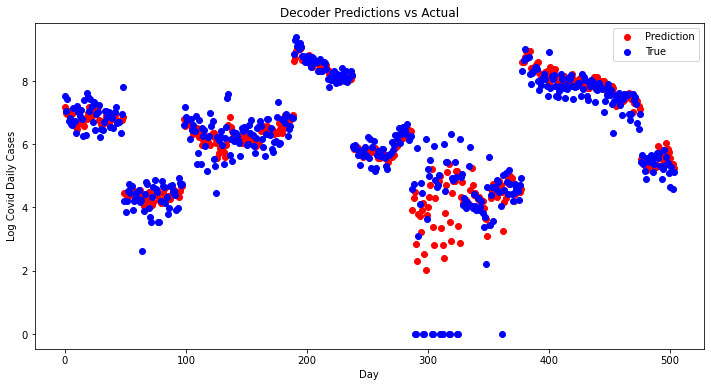

In [241]:
# Plot predictions vs actual test data
b_window = 0
e_window = 500
p = np.ndarray.flatten(np.array(d_test_preds[b_window:e_window:7]))
t = np.ndarray.flatten(d_y_test_np[b_window:e_window:7])
num = len(p)

fig, ax = plt.subplots(figsize=(12, 6))
    
# Plot the predictions and true values
ax.scatter(range(num), p, color = 'red', label = 'Prediction')
ax.scatter(range(num), t, color = 'blue', label = 'True')

ax.legend()
ax.set_title("Decoder Predictions vs Actual")
ax.set_xlabel('Day')
ax.set_ylabel('Log Covid Daily Cases')
plt.show()

# Functions for Counterfactual Predictions

In [61]:
# Generate set of predictions based on the input_seq
# and the future strictness values. The encoder first gets a
# representation of the input_seq in its hidden state and cell state.
# This is passed to the decoder, which uses the future
# strictness values to predict the future cases. It 
# recursively passes in decoder outputs as inputs
def predict(input_seq, strictnesses, starting_case_num, encoder, decoder):
    # Set the encoder initial state
    e_initial_states = encoder.init_states(1)
    e_outputs = encoder(tf.constant([input_seq]), e_initial_states)

    # Set the decoder states to the encoder vector or encoder hidden state    
    predictions = []
    states = e_outputs[1:]
    last_case_num = starting_case_num
    for s in strictnesses:
        d_input = np.array([[[s, last_case_num]]], dtype=object).astype('float32')

        # Decode and get the predicted daily case count
        d_output = decoder(tf.constant(d_input), states)
        predictions.append(d_output[0][0][0].numpy()[0])
        last_case_num = d_output[0]
        states = d_output[1:]
        
    return predictions
    

In [198]:
# Plot the encoder/decoder predictions for a particular set of policy
# strictnesses on a particular simulation date
def simulate(sim_date, sim_days, state, policy, encoder, decoder, ind_dd, data, seed_length, type_sim):
    e_X = data[0]
    e_y = data[1]
    d_X = data[2]
    d_y = data[3]
    
    # We will seed the encoder with the week before sim_date
    seed_date = pd.to_datetime(sim_date) - pd.Timedelta(days=seed_length)
    seed_date = str(seed_date)[0:10]
    
    # We need to get the indxes corresponding
    # to the simulation date and seed date in our dataset
    sim_index = ind_dd[state][sim_date]
    seed_index = ind_dd[state][seed_date]
    
    # Grab starting sequence and case count
    encoder_seed = e_X[seed_index]
    starting_cases = e_y[seed_index][-1]
    
    if policy == None:
        # If no custom policy was given, use the true policy
        # values for state between sim_date and sim_date + sim_days
        i = sim_index
        policy = d_X[i][:, 0]
        while len(policy) < sim_days and i < list(ind_dd[state].values())[-1] - seed_length + 1:
            i += 7
            policy = np.concatenate((policy, d_X[i][:, 0]))
            
        policy = policy[:sim_days]    
        
    # Predict the future log cases base on the encoder seed and policy strictnesses
    decoder_preds = predict(encoder_seed, policy, starting_cases, encoder, decoder)
    
    true_values = []
    # Get the true values for the future
    for j in range(sim_days):
        true_values.append(e_y[sim_index + j][0])
        
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the predictions and true values
    ax.plot(true_values, color = 'red', label = 'True')
    ax.plot(decoder_preds, color = 'blue', label = 'Forecast')
    
    ax.legend()
    ax.set_title("{} Policy Simulation for {} on {}".format(type_sim, state, sim_date))
    ax.set_xlabel('Day')
    ax.set_ylabel('Log Covid Daily Cases')
    plt.show()
    

# Making some counterfactual predictions

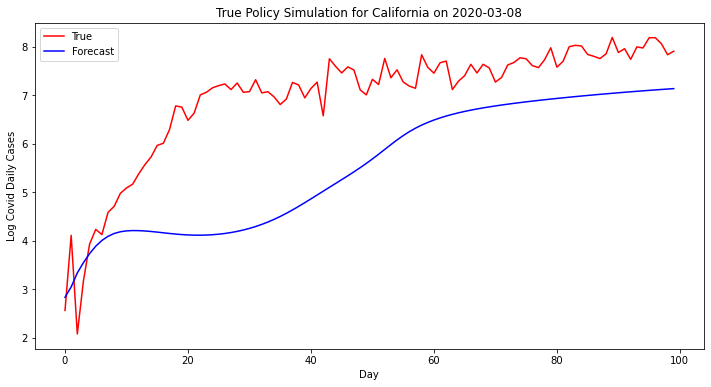

In [199]:
simulate("2020-03-08", 100, "California", None, encoder, decoder, train_dd, 
         [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 7, "True")

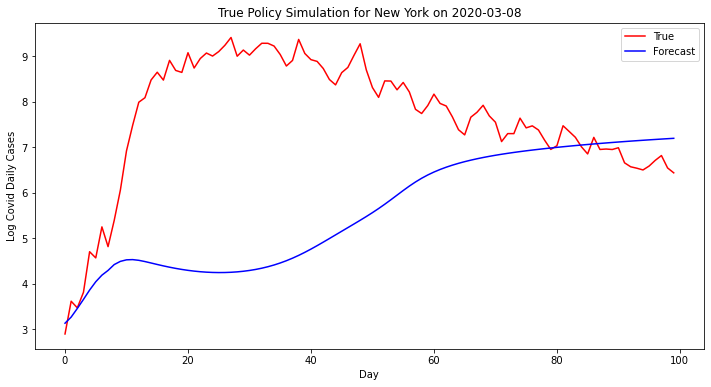

In [204]:
simulate("2020-03-08", 100, "New York", None, encoder, decoder, train_dd, 
         [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 7, "True")

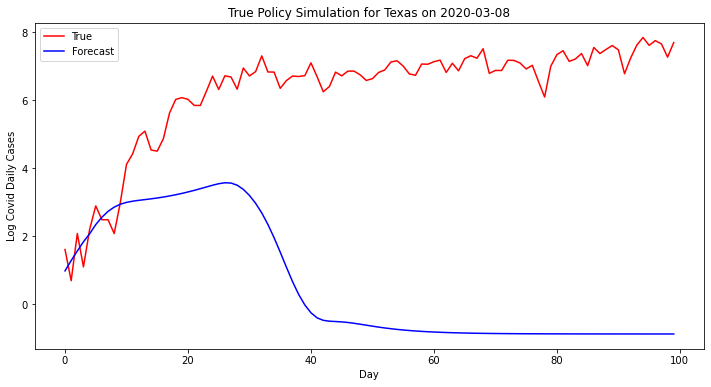

In [205]:
simulate("2020-03-08", 100, "Texas", None, encoder, decoder, train_dd, 
         [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 7, "True")

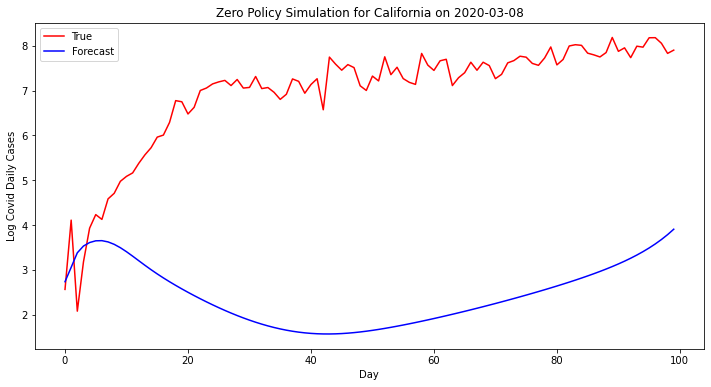

In [200]:
simulate("2020-03-08", 100, "California", [0] * 100, encoder, decoder, train_dd, 
         [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 7, "Zero")

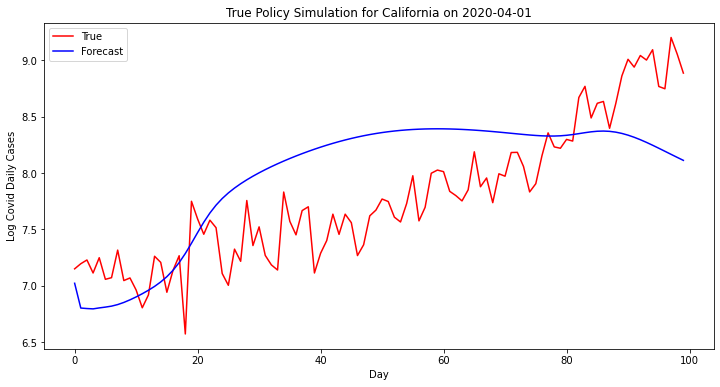

In [202]:
simulate("2020-04-01", 100, "California", None, encoder, decoder, train_dd, 
         [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 7, "True")

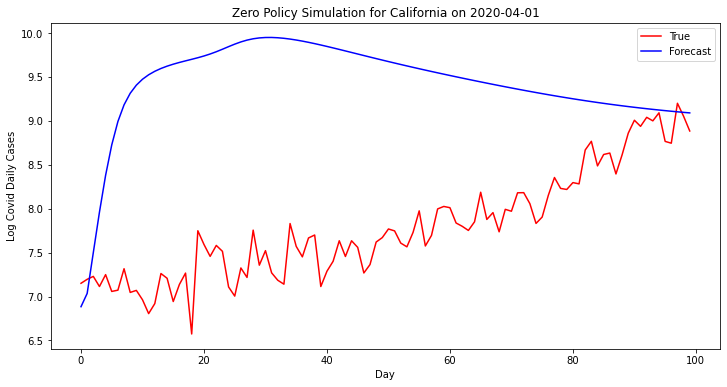

In [201]:
simulate("2020-04-01", 100, "California", [0] * 100, encoder, decoder, train_dd, 
         [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 7, "Zero")

# Gridsearching for optimal parameters

t: 7 l: 0.02 h:50


/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 1 Training Loss 2.8789
Epoch 1 Validation Loss 1.2445
Time taken for 1 epoch 9.6996 sec

Epoch 11 Training Loss 0.7013
Epoch 11 Validation Loss 0.6980
Time taken for 1 epoch 9.6819 sec

Epoch 21 Training Loss 0.6784
Epoch 21 Validation Loss 0.7458
Time taken for 1 epoch 9.4944 sec

Epoch 1 Training Loss 1.0614
Epoch 1 Validation Loss 0.5527
Time taken for 1 epoch 18.5512 sec

Epoch 11 Training Loss 0.4992
Epoch 11 Validation Loss 0.5460
Time taken for 1 epoch 17.5900 sec

Epoch 21 Training Loss 0.4680
Epoch 21 Validation Loss 0.5461
Time taken for 1 epoch 17.6035 sec



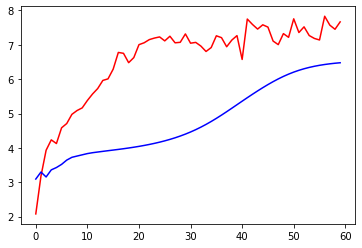

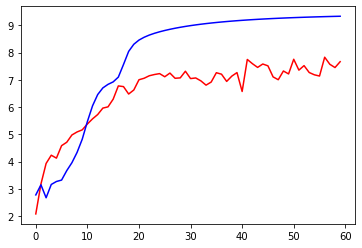

t: 7 l: 0.02 h:100


/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 1 Training Loss 2.0611
Epoch 1 Validation Loss 0.9188
Time taken for 1 epoch 10.7974 sec

Epoch 11 Training Loss 0.8070
Epoch 11 Validation Loss 0.7667
Time taken for 1 epoch 10.3093 sec

Epoch 21 Training Loss 0.6967
Epoch 21 Validation Loss 0.9231
Time taken for 1 epoch 10.3449 sec

Epoch 1 Training Loss 1.0585
Epoch 1 Validation Loss 0.5022
Time taken for 1 epoch 19.0157 sec

Epoch 11 Training Loss 0.5077
Epoch 11 Validation Loss 0.4658
Time taken for 1 epoch 20.6290 sec

Epoch 21 Training Loss 0.4597
Epoch 21 Validation Loss 0.4864
Time taken for 1 epoch 20.8714 sec



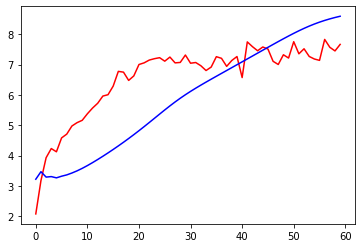

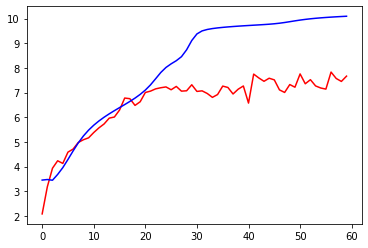

t: 7 l: 0.02 h:150


/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 1 Training Loss 1.9898
Epoch 1 Validation Loss 1.4763
Time taken for 1 epoch 11.6629 sec

Epoch 11 Training Loss 0.7455
Epoch 11 Validation Loss 0.9079
Time taken for 1 epoch 12.6230 sec

Epoch 21 Training Loss 0.6611
Epoch 21 Validation Loss 0.7397
Time taken for 1 epoch 11.4684 sec

Epoch 1 Training Loss 1.0292
Epoch 1 Validation Loss 0.5882
Time taken for 1 epoch 21.8379 sec

Epoch 11 Training Loss 0.4983
Epoch 11 Validation Loss 0.5438
Time taken for 1 epoch 19.8100 sec

Epoch 21 Training Loss 0.4519
Epoch 21 Validation Loss 0.5491
Time taken for 1 epoch 22.6165 sec



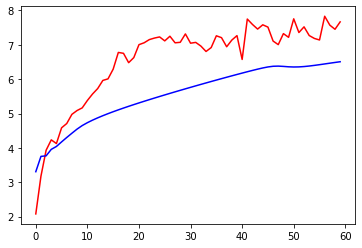

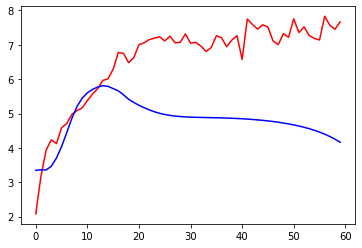

In [135]:
# Run a loop to search for optimal simulation parameters for our
# encoder/decoder LSTM model
hidden_units = [50, 100, 150]
learning_rates = [0.02]
time_steps = [7]
for t in time_steps:
    for l in learning_rates:
        for h in hidden_units:
            print("t: {} l: {} h:{}".format(t, l, h))
            
            # Grab initial dataframe
            input_df = get_input_df()

            # Grab time window to split training and test data
            train_start = "2020-03-01"
            train_end = "2020-08-01"
            test_start = "2020-08-01"
            test_end = "2020-10-01"
            train_df = input_df.loc[(input_df['date'] >= train_start) & 
                                    (input_df['date'] < train_end)].copy().reset_index(drop=True)
            test_df = input_df.loc[(input_df['date'] >= test_start) & 
                                    (input_df['date'] < test_end)].copy().reset_index(drop=True)

            # Get input and output for training
            e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np, train_dd = create_dataset(train_df, t)

            # Get input and output for testing
            e_x_test_np, e_y_test_np, d_x_test_np, d_y_test_np, test_dd = create_dataset(test_df, t)

            # train encoder
            encoder = ED_LSTM(h)
            lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=l,
                decay_steps=10000,
                decay_rate=0.1)
            optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

            checkpoint_dir = './training_ckpt_encoder'
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                             encoder=encoder)
            losses = encoder_train(encoder, [e_x_train_np, e_y_train_np], 25, 32, 
                                   optimizer, checkpoint, checkpoint_prefix, 0)

            # train decoder
            decoder = ED_LSTM(h)
            lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=l,
                decay_steps=10000,
                decay_rate=0.1)
            optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

            checkpoint_dir = './training_ckpt_decoder'
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                             decoder=decoder)
            d_losses = decoder_train(encoder, decoder, 
                                     [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 
                                     25, 32, optimizer, checkpoint, checkpoint_prefix, 0)

            # Simulate with encoder and decoder
            simulate("2020-03-10", 60, "California", None, encoder, decoder, train_dd, 
                     [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], t)

            simulate("2020-03-10", 60, "California", [0] * 60, encoder, decoder, train_dd, 
                     [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], t)
